# Hands-on session with pke

## Part 1 : graph-based keyphrase extraction with TopicRank

[TopicRank (Bougouin et al., 2013)](https://aclanthology.org/I13-1062/) is an unsupervised graph-based keyphrase extraction model that is often used as a baseline by the research community.
TopicRank relies on a graph-based topical representation of the input document, and uses a random walk algorithm derived from PageRank to estimate the importance of each topic (node).
Phrase candidates belonging to the highest-scored topics are then selected as keyphrases

This notebook presents an end-to-end example of keyphrase extraction using TopicRank implemented in `pke`.

Keyphrase extraction is usually described as a three-stage process involving identifying keyphrase candidates, weighting these candidates and selecting the N-best candidates as keyphrases.

`pke` provides a standardized API for extracting keyphrases from a document :

```python
import pke

# initialize a keyphrase extraction model, here TopicRank
extractor = pke.unsupervised.TopicRank()

# load the content of the document (file or str) and use spacy for preprocessing
extractor.load_document(input='/path/to/input.txt', language='en')

# identify keyphrase candidates (for TopicRank, sequences of nouns and adjectives)
extractor.candidate_selection()

# weight candidates (for TopicRank, using a random walk algorithm)
extractor.candidate_weighting()

# select the 10-best candidates as keyphrases as (keyphrase, score) tuples
keyphrases = extractor.get_n_best(n=10)
```

### Let's start by importing `pke` and initializing a `TopicRank` model

In [1]:
import pke

# initialize a TopicRank keyphrase extraction model
extractor = pke.unsupervised.TopicRank()

### What we need now is a sample document

In [2]:
# sample document (2040.abstr from the Hulth-2003 dataset)
sample = """Inverse problems for a mathematical model of ion exchange in a compressible ion exchanger.
A mathematical model of ion exchange is considered, allowing for ion exchanger compression in the process
of ion exchange. Two inverse problems are investigated for this model, unique solvability is proved, and
numerical solution methods are proposed. The efficiency of the proposed methods is demonstrated by a
numerical experiment."""

# normalize spacing (replace newlines with whitespaces)
sample = sample.replace("\n", " ")

### Then, we can load the sample document using the pke model

When raw text is given to a `pke` model, `spacy`/`nltk` is used to pre-process the text (sentence splitting, tokenization, Part-of-Speech tagging, stemming).

In [3]:
# load the document using the initialized model
# text preprocessing is carried out using spacy
extractor.load_document(input=sample, language='en')

In [4]:
# let's have a look at the pre-processed text

# for each sentence in the document
for i, sentence in enumerate(extractor.sentences):
    
    # print out the sentence id, its tokens, its stems and the corresponding Part-of-Speech tags
    print("sentence {}:".format(i))
    print(" - words: {} ...".format(' '.join(sentence.words[:5])))
    print(" - stems: {} ...".format(' '.join(sentence.stems[:5])))
    print(" - PoS: {} ...".format(' '.join(sentence.pos[:5])))

sentence 0:
 - words: Inverse problems for a mathematical ...
 - stems: invers problem for a mathemat ...
 - PoS: NOUN NOUN ADP DET ADJ ...
sentence 1:
 - words: A mathematical model of ion ...
 - stems: a mathemat model of ion ...
 - PoS: DET ADJ NOUN ADP NOUN ...
sentence 2:
 - words: Two inverse problems are investigated ...
 - stems: two invers problem are investig ...
 - PoS: NUM NOUN NOUN VERB VERB ...
sentence 3:
 - words: The efficiency of the proposed ...
 - stems: the effici of the propos ...
 - PoS: DET NOUN ADP DET VERB ...


### Step-1 : Identifying keyphrase candidates

In [5]:
# identify the keyphrase candidates using TopicRank's default strategy
# i.e. the longest sequences of nouns and adjectives `(Noun|Adj)*`
extractor.candidate_selection()

In [6]:
# let's have a look at the keyphrase candidates

# for each keyphrase candidate
for i, candidate in enumerate(extractor.candidates):
    
    # the candidate is in stemmed form, we can find the (first occurring)
    # surface form using the candidates dictionary structure
    surface_form = ' '.join(extractor.candidates[candidate].surface_forms[0]).lower()
    
    # print out the candidate id, its stemmed form and first occurring surface form
    print("candidate {}: {} (stemmed) ; {}".format(i, candidate, surface_form))

candidate 0: invers problem (stemmed) ; inverse problems
candidate 1: mathemat model (stemmed) ; mathematical model
candidate 2: ion exchang (stemmed) ; ion exchange
candidate 3: compress ion exchang (stemmed) ; compressible ion exchanger
candidate 4: ion exchang compress (stemmed) ; ion exchanger compression
candidate 5: process (stemmed) ; process
candidate 6: model (stemmed) ; model
candidate 7: uniqu solvabl (stemmed) ; unique solvability
candidate 8: numer solut method (stemmed) ; numerical solution methods
candidate 9: effici (stemmed) ; efficiency
candidate 10: method (stemmed) ; methods
candidate 11: numer experi (stemmed) ; numerical experiment


### Step-2 : Ranking keyphrase candidates

In [7]:
# In TopicRank, candidate weighting is a three-step process:
#  1. candidate clustering (grouping keyphrase candidates into topics)
#  2. graph construction (building a complete-weighted-graph of topics)
#  3. rank topics (nodes) using a random walk algorithm
extractor.candidate_weighting()

In [8]:
# let's have a look at the topics

# for each topic of the document
for i, topic in enumerate(extractor.topics):
    
    # print out the topic id and the candidates it groups together
    print("topic {}: {} ".format(i, ';'.join(topic)))

topic 0: method;numer solut method 
topic 1: numer experi 
topic 2: mathemat model;model 
topic 3: compress ion exchang;ion exchang;ion exchang compress 
topic 4: effici 
topic 5: invers problem 
topic 6: process 
topic 7: uniqu solvabl 


<IPython.core.display.Javascript object>


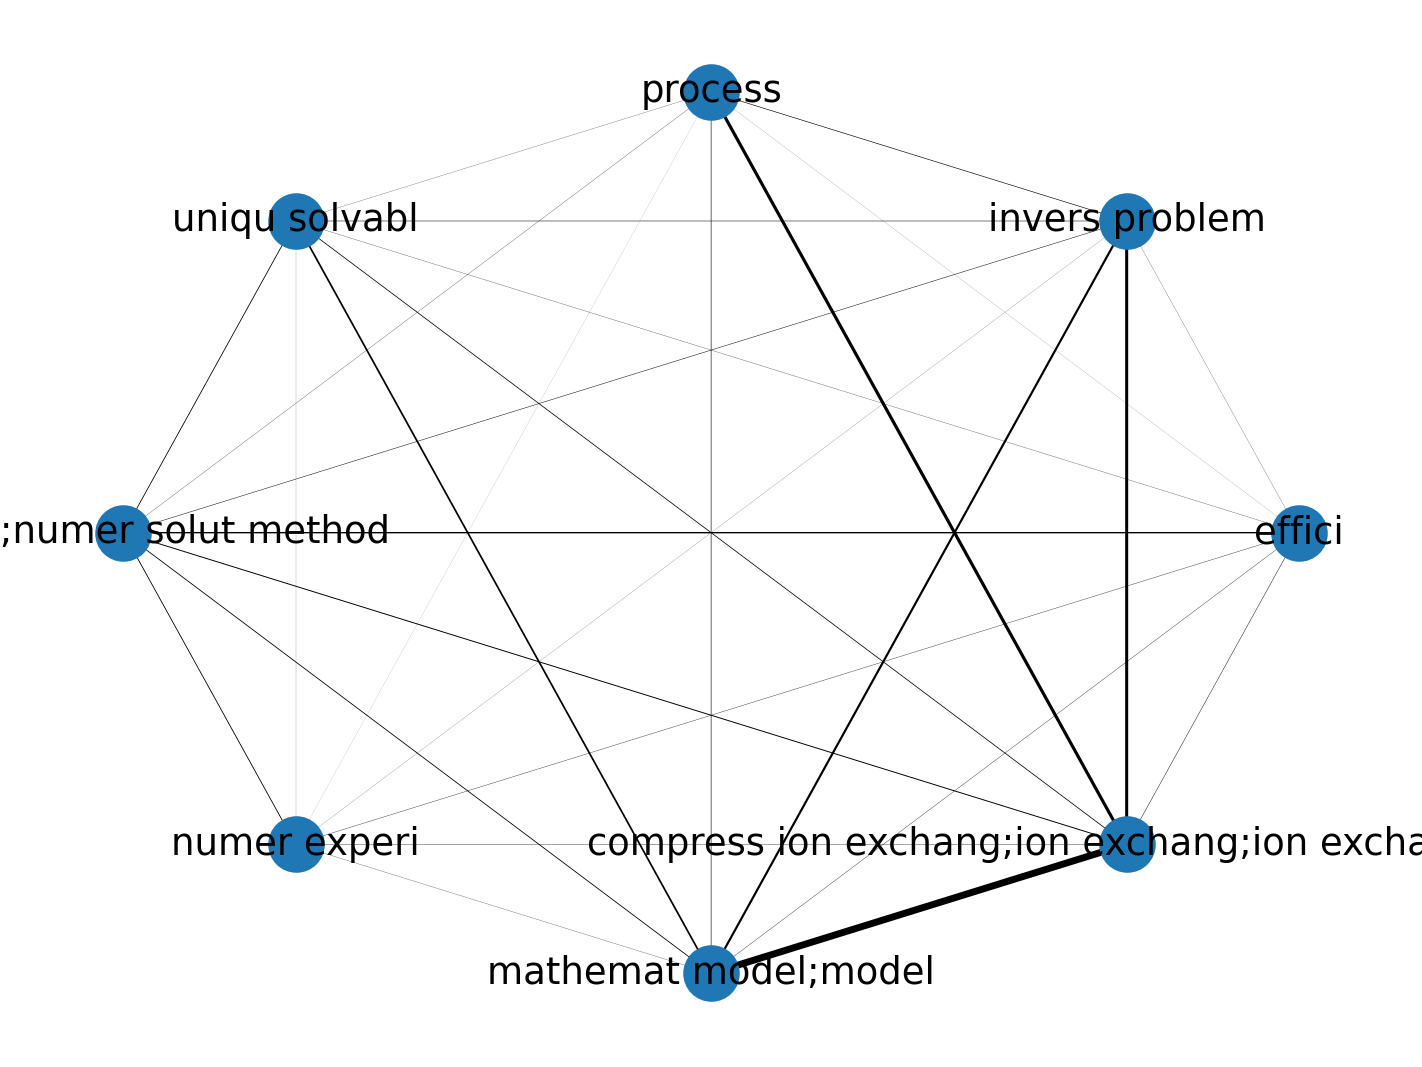

In [9]:
# let have a look at the graph-based representation of the document
#
# here, nodes are topics, edges between topics are weighted according to 
# the strength of their semantic relation measured by the reciprocal distances
# between the offset positions of the candidate keyphrases

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib notebook

# set the labels as list of candidates for each topic
labels = {i: ';'.join(topic) for i, topic in enumerate(extractor.topics)}

# set the weights of the edges
weights = [extractor.graph[u][v]['weight'] for u,v in extractor.graph.edges()]

# draw the graph
nx.draw_shell(extractor.graph, with_labels=True, labels=labels, width=weights)

In [10]:
# let's have a look at the weights/ranks of the topics

# In TopicRank, weights are computed for each topic, and only one
# representative candidate per topic (by default the first occurring
# one) is kept

# for each representative candidate
for candidate, weight in extractor.weights.items():
    
    # print out the candidate (in stemmed form) and its weight
    print('{}: {}'.format(candidate, weight))

numer solut method: 0.1123051810713309
numer experi: 0.05384349097107629
mathemat model: 0.20956615609606072
ion exchang: 0.252745659150394
effici: 0.06978124102113362
invers problem: 0.12382648206384317
process: 0.09168033164149342
uniqu solvabl: 0.08625145798466828


### Step-3: Selecting the N-best candidates as keyphrases

In [11]:
# Get the N-best candidates (here, 5) as keyphrases
keyphrases = extractor.get_n_best(n=5, stemming=False)

# for each of the best candidates
for i, (candidate, score) in enumerate(keyphrases):
    
    # print out the its rank, phrase and score
    print("rank {}: {} ({})".format(i, candidate, score))

rank 0: ion exchange (0.252745659150394)
rank 1: mathematical model (0.20956615609606072)
rank 2: inverse problems (0.12382648206384317)
rank 3: numerical solution methods (0.1123051810713309)
rank 4: process (0.09168033164149342)


## Conclusion

This notebook shows how an end-to-end example of graph-based keyphrase extraction using TopicRank implemented within the `pke` toolkit.

Now that we are familiar with the three-stage process involved in keyphrase extraction (candidate selection, candidate ranking, N-best selection), as well as with the `pke` API, we are ready for part-2 in which experiment with different models and parameters and see how to evaluate the quality of the produced keyphrases.